In [9]:
import pandas as pd
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.models import TransE, ComplEx, ConvE, DistMult
from pykeen.evaluation import RankBasedEvaluator

import pandas as pd

import tkinter as tk
from tkinter import filedialog, messagebox
from neo4j import GraphDatabase
import pandas as pd
from nltk.tokenize import word_tokenize


#visualisation
import matplotlib.pyplot as plt
import random
import torch
#from pyDatalog import pyDatalog
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

#interface
import tkinter as tk
from tkinter import filedialog, messagebox
import nltk

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data
from sklearn.metrics import f1_score
import torch

from collections import defaultdict
from py2neo import Graph, Node, Relationship
import ipywidgets as widgets
from IPython.display import display
import torch_geometric
import torch_scatter
import torch_sparse
import torch_cluster
import torch_spline_conv
from tqdm import tqdm

from rdflib import Graph, URIRef, Namespace
from urllib.parse import quote

from rdflib import Graph, URIRef, Literal, Namespace, RDF
import pycountry
from geopy.geocoders import Nominatim


from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap  # Correct import for UMAP
#import umap
import torch
import torch.nn as nn
import torch.optim as optim
import csv

## Setup and exploration

In [10]:
# Load your CSV into a DataFrame
df = pd.read_csv('data1.csv') 

# Add a running ID column
df['ID'] = range(1, len(df) + 1)

# Save the updated DataFrame 
df.to_csv('data1.csv', index=False)

print(df.head())  # print the first few rows to verify

                      head       relationship                  tail  ID
0            Abraham Trust          partnered    Geoffrey Jenkinson   1
1  Benjamin Bishop Johnson  appraised_art_for         David Swetnam   2
2             Donald Hales  appraised_art_for    Leonardo Patterson   3
3           Giacomo Medici  appraised_art_for   Nikolas Koutoulakis   4
4               Jack Ogden  appraised_art_for  Michael Ward Gallery   5


In [11]:
# Load Data
dtype_spec = {'head': 'category', 'relationship': 'category', 'tail': 'category'}
#originally data.csv, but since labeling requires cleaning up the text, we take the clean version
dataset = pd.read_csv('data1.csv', usecols=['head', 'relationship', 'tail'], dtype=dtype_spec)

# Display first few rows
print("Dataset:")
print(dataset)

# Generate Triples as (head, relationship, tail)
triples = dataset[['head', 'relationship', 'tail']].drop_duplicates().values.tolist()

# Create a Triples Factory
triples_array = np.array(triples)
triples_factory = TriplesFactory.from_labeled_triples(triples_array)

# Verify the content
print("Triples Stats:")
print(triples_factory)



Dataset:
                         head         relationship                   tail
0               Abraham Trust            partnered     Geoffrey Jenkinson
1     Benjamin Bishop Johnson    appraised_art_for          David Swetnam
2                Donald Hales    appraised_art_for     Leonardo Patterson
3              Giacomo Medici    appraised_art_for    Nikolas Koutoulakis
4                  Jack Ogden    appraised_art_for   Michael Ward Gallery
...                       ...                  ...                    ...
1199             Robert Hecht  sold_antiquities_to            Marion True
1200           Giacomo Medici  sold_antiquities_to            Marion True
1201             Robert Hecht      implicated_with            Marion True
1202           Giacomo Medici      implicated_with            Marion True
1203                Sotheby's             returned  Empress Dou Figurines

[1204 rows x 3 columns]
Triples Stats:
TriplesFactory(num_entities=477, num_relations=81, create_inver

In [4]:
# Create the graph
G = nx.DiGraph()

# Add edges to the graph
for head, relationship, tail in triples:
    G.add_edge(head, tail, label=relationship)

# Add node labels to the graph for exploration and visualisation after the labels were first generated
if os.path.exists('results/generated_labels.csv'):
    labels = pd.read_csv('results/generated_labels.csv')
    labels_dict = dict(zip(labels['text'], labels['label']))
else:
    labels_dict = {}

for node, label in labels_dict.items():
    if node in G.nodes:
        G.nodes[node]['label'] = label

# Verify the content
print("Graph Information:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Find nodes without a label
nodes_without_label = [n for n, d in G.nodes(data=True) if 'label' not in d]

# Print nodes without a label
if nodes_without_label:
    print("Nodes without labels:", nodes_without_label)
else:
    print("All nodes have labels.")

NameError: name 'os' is not defined

['accepted_material_from', 'acquired', 'acted_for', 'alias', 'appraised_art_for', 'arrested', 'auctioned_for', 'authenticated', 'base_for', 'belonged_to', 'bought_from', 'caught_by', 'consigned_through', 'contains', 'created_by', 'curator_of', 'director_of', 'displayed_at', 'donated_to', 'employed', 'exhibited', 'from_culture', 'gave', 'given_by', 'held_by', 'hired', 'home_of', 'implicated_by', 'implicated_with', 'implicates', 'investigated', 'led_by', 'lived_in', 'looted_by', 'looted_from', 'made', 'offered_for_sale', 'operated_in', 'origin_for', 'owned', 'part_of', 'partnered', 'possessed', 'president_of', 'probed_by', 'purchased_by', 'raided', 'raided_by', 'received_antiquities_from', 'refused', 'regained', 'rejected_by', 'related_to', 'relationship_with', 'repatriated_to', 'represented_by', 'returned', 'returned_by', 'robbed_of', 'shipped_to', 'smuggled', 'smuggled_antiquities_from', 'smuggled_antiquities_through', 'smuggled_antiquities_to', 'sold', 'sold_antiquities_from', 'sold_a

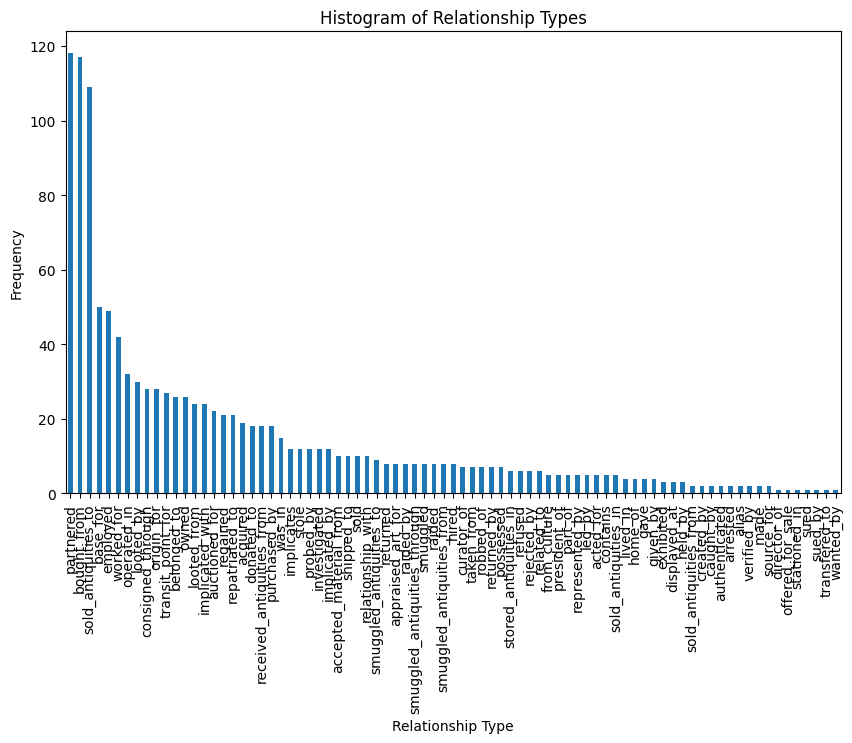

In [112]:
# Histogram of all types of relationships
all_relationships = dataset['relationship'].cat.categories.tolist()
print(all_relationships)
relationship_counts = dataset['relationship'].value_counts()
plt.figure(figsize=(10, 6))
relationship_counts.plot(kind='bar')
plt.title('Histogram of Relationship Types')
plt.xlabel('Relationship Type')
plt.ylabel('Frequency')
plt.savefig("output_images/histogram_relationships.png")
plt.show()

/tmp/ipykernel_33440/2126440552.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', len(all_relationships))


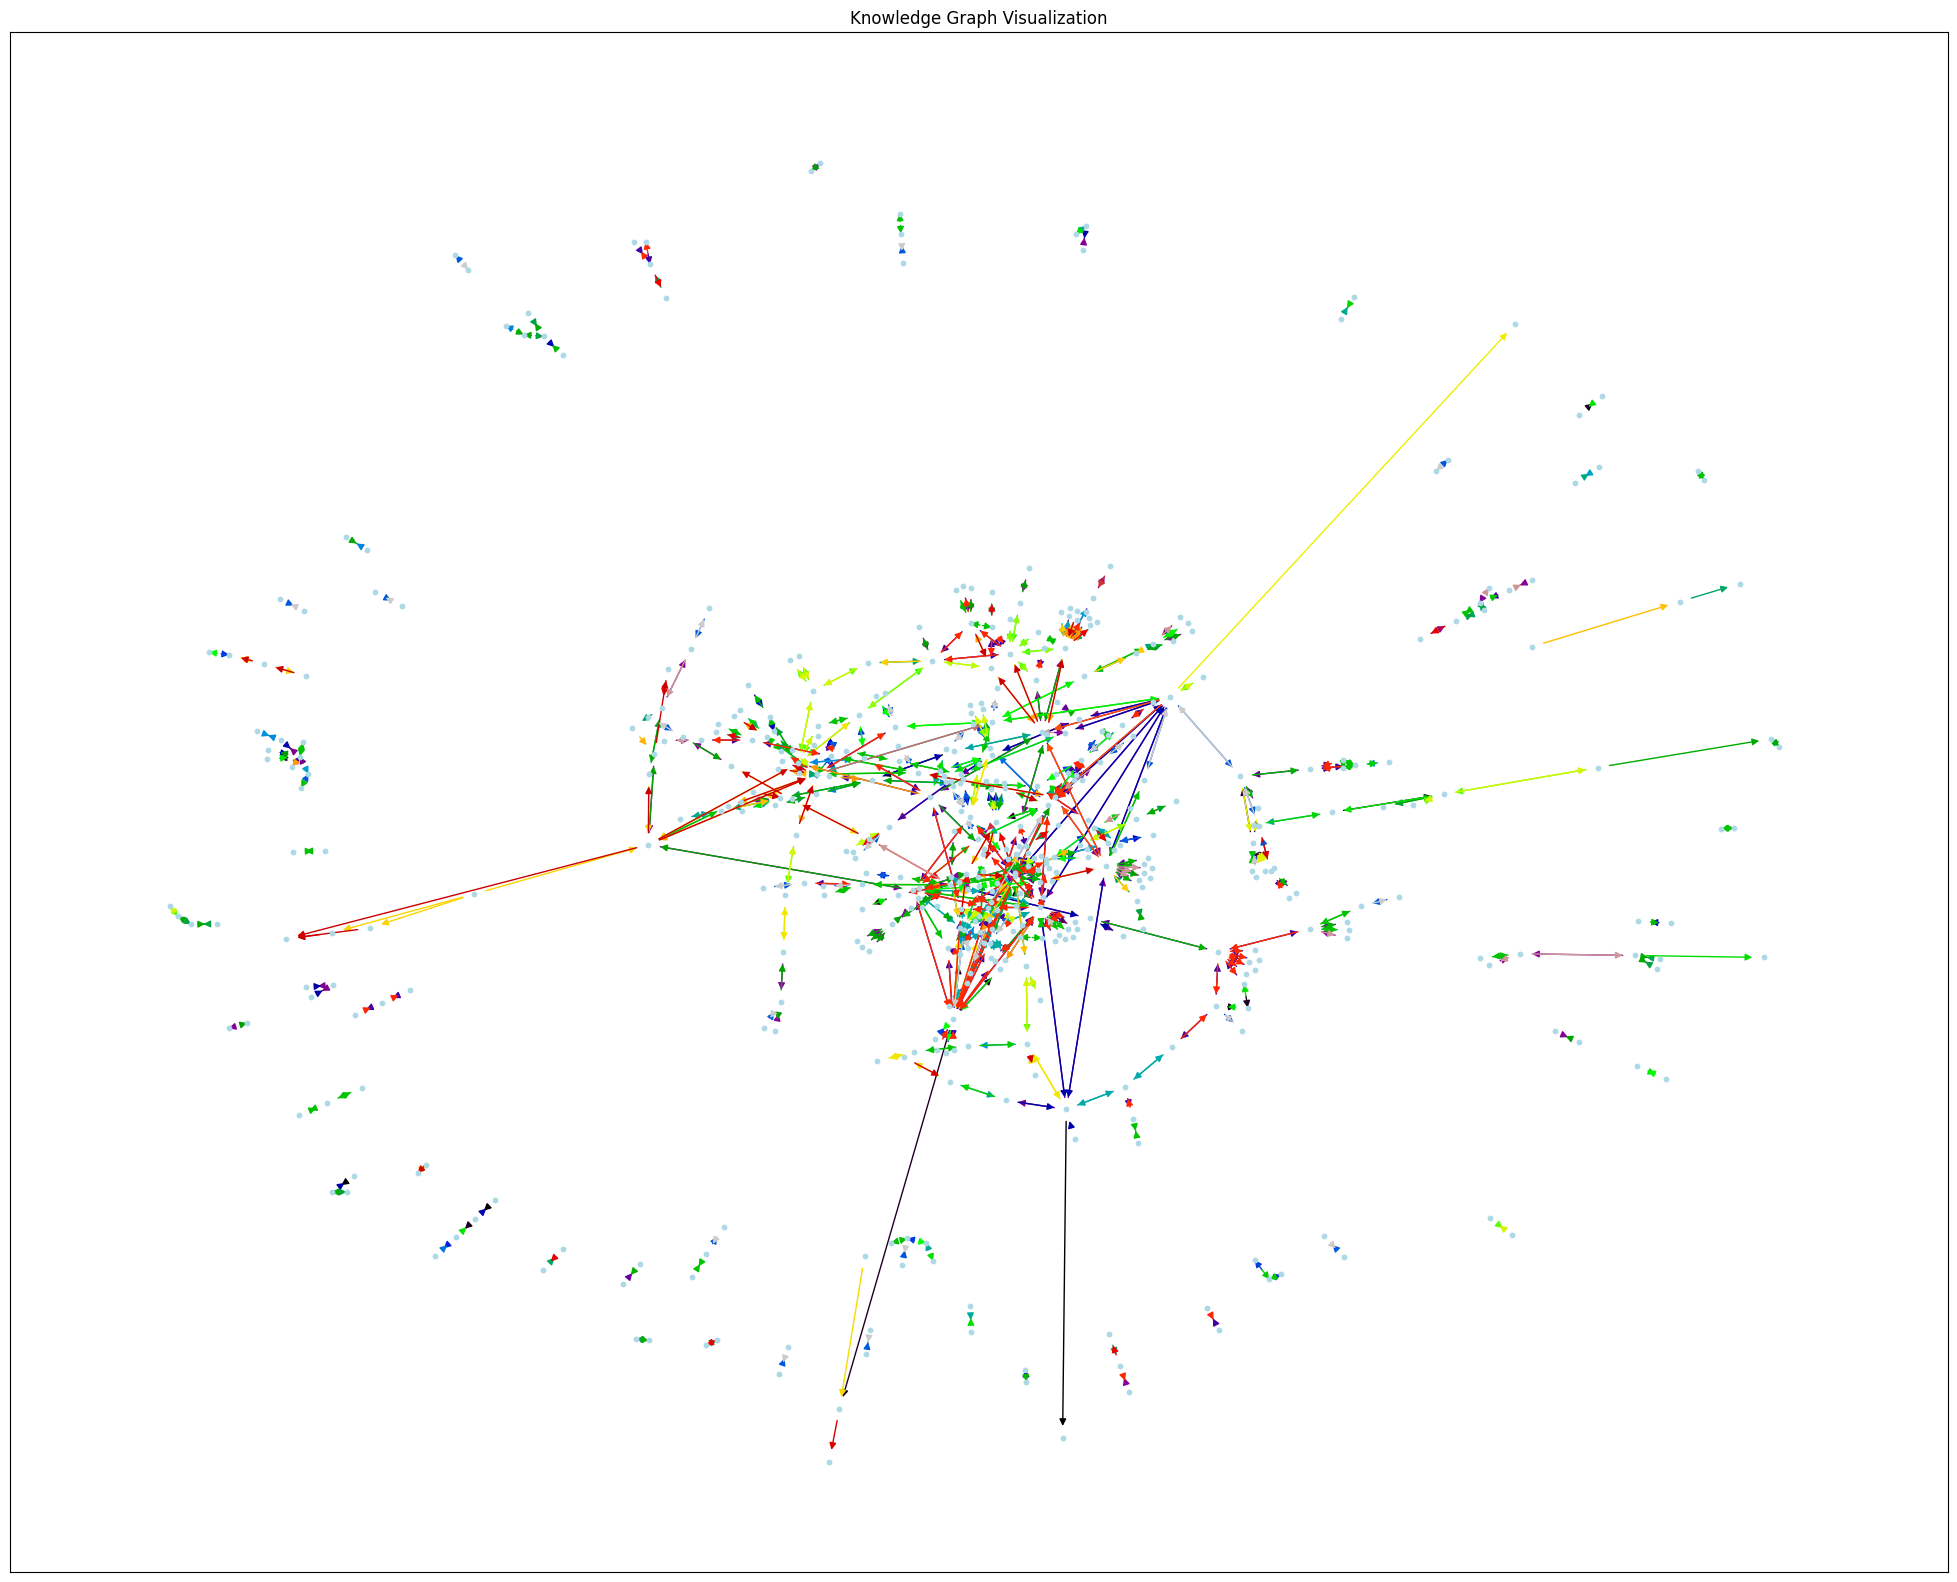

In [ ]:
#Plot the graph
# Create a color map for each type of relationship
cmap = plt.cm.get_cmap('nipy_spectral', len(all_relationships))

# Assign a color to each relationship type
relationship_colors = {rel: cmap(i % cmap.N) for i, rel in enumerate(all_relationships)}


# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

plt.figure(figsize=(25, 20))

# Draw edges with colors based on relationships
for rel, color in relationship_colors.items():
    edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == rel]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[color], label=rel)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')

# Draw labels
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Create a legend
labels = {rel: rel for rel in relationship_colors.keys()}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
#plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2) for color in relationship_colors.values()],
           #labels=relationship_colors.keys(), title="Relationship Types")

plt.title('Knowledge Graph Visualization')

plt.savefig("output_images/knowledge_graph.png")
plt.show()

## Embedding Models

In [114]:
# Set a random seed 
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Split into training, validation, and testing sets
training_factory, testing_factory, validation_factory = triples_factory.split([0.8, 0.1, 0.1])
print(training_factory)

using automatically assigned random_state=4289512057


TriplesFactory(num_entities=477, num_relations=81, create_inverse_triples=False, num_triples=963)


In [115]:
# Define a function to train and evaluate an embedding model
def train_and_evaluate_model(model_cls, training_factory, testing_factory, validation_factory, random_seed):
    # Pipeline setup
    pipeline_result = pipeline(
        model=model_cls,
        training=training_factory,
        testing=testing_factory,
        validation=validation_factory,
        training_kwargs=dict(num_epochs=1000),
        random_seed=random_seed,
    )

    # Model evaluation
    evaluator = RankBasedEvaluator()
    results = evaluator.evaluate(
        model=pipeline_result.model,
        mapped_triples=testing_factory.mapped_triples,
        additional_filter_triples=[training_factory.mapped_triples, validation_factory.mapped_triples]
    )

    # Summarize results
    print(f"{model_cls.__name__} Results:\n")
    print(results.to_dict())

    return pipeline_result, results

In [116]:
transE_result, transE_results = train_and_evaluate_model(TransE, training_factory, testing_factory, validation_factory, random_seed)


No cuda devices were available. The model runs on CPU


/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


TransE Results:

{'head': {'optimistic': {'adjusted_arithmetic_mean_rank_index': 0.8696964379715739, 'count': 120.0, 'standard_deviation': 70.23108236782028, 'median_rank': 6.0, 'adjusted_arithmetic_mean_rank': 0.13395072514415515, 'median_absolute_deviation': 5.930408874022408, 'inverse_arithmetic_mean_rank': 0.031307070180015655, 'geometric_mean_rank': 9.225864291212872, 'z_geometric_mean_rank': 10.717005334648455, 'adjusted_inverse_harmonic_mean_rank': 0.2043147253024838, 'adjusted_geometric_mean_rank_index': 0.9533290865980358, 'variance': 4932.404930555555, 'harmonic_mean_rank': 4.638447272365253, 'inverse_median_rank': 0.16666666666666666, 'inverse_harmonic_mean_rank': 0.2155893861201696, 'inverse_geometric_mean_rank': 0.10839092885340237, 'arithmetic_mean_rank': 31.941666666666666, 'z_arithmetic_mean_rank': 16.46652151692661, 'z_inverse_harmonic_mean_rank': 38.696243860826975, 'hits_at_1': 0.0, 'hits_at_3': 0.325, 'hits_at_5': 0.45, 'hits_at_10': 0.625, 'z_hits_at_k': 46.1307948

In [117]:
complEx_result, complEx_results = train_and_evaluate_model(ComplEx, training_factory, testing_factory, validation_factory, random_seed)

INFO:pykeen.pipeline.api:Using device: None
/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


ComplEx Results:

{'head': {'optimistic': {'adjusted_arithmetic_mean_rank_index': 0.06692402175820333, 'count': 120.0, 'standard_deviation': 139.87975391583856, 'median_rank': 219.5, 'adjusted_arithmetic_mean_rank': 0.9333566311375152, 'median_absolute_deviation': 183.10137398544185, 'inverse_arithmetic_mean_rank': 0.004493035794518496, 'geometric_mean_rank': 151.4334344907398, 'z_geometric_mean_rank': 1.6467799401932925, 'adjusted_inverse_harmonic_mean_rank': 0.011916202508973624, 'adjusted_geometric_mean_rank_index': 0.14648898336709992, 'variance': 19566.345555555552, 'harmonic_mean_rank': 38.584560659877724, 'inverse_median_rank': 0.004555808656036446, 'inverse_harmonic_mean_rank': 0.025917102149094914, 'inverse_geometric_mean_rank': 0.006603561514423357, 'arithmetic_mean_rank': 222.56666666666666, 'z_arithmetic_mean_rank': 1.2671155085456824, 'z_inverse_harmonic_mean_rank': 2.2568724672173004, 'hits_at_1': 0.008333333333333333, 'hits_at_3': 0.025, 'hits_at_5': 0.025, 'hits_at_10':

In [118]:
convE_result, convE_results = train_and_evaluate_model(ConvE, training_factory, testing_factory, validation_factory, random_seed)

INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3 (33.33%) batches).


Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.29s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.27s seconds


ConvE Results:

{'head': {'optimistic': {'adjusted_arithmetic_mean_rank_index': 0.6980522898754168, 'count': 120.0, 'standard_deviation': 109.56395392646252, 'median_rank': 14.5, 'adjusted_arithmetic_mean_rank': 0.30487506552507426, 'median_absolute_deviation': 20.015129949825628, 'inverse_arithmetic_mean_rank': 0.013755158184319119, 'geometric_mean_rank': 16.504512406288143, 'z_geometric_mean_rank': 10.252761561422952, 'adjusted_inverse_harmonic_mean_rank': 0.23177413510363173, 'adjusted_geometric_mean_rank_index': 0.912032373713418, 'variance': 12004.260000000002, 'harmonic_mean_rank': 4.120997379293598, 'inverse_median_rank': 0.06896551724137931, 'inverse_harmonic_mean_rank': 0.24265970297011333, 'inverse_geometric_mean_rank': 0.060589490642510874, 'arithmetic_mean_rank': 72.7, 'z_arithmetic_mean_rank': 13.216672564489837, 'z_inverse_harmonic_mean_rank': 43.89692636849489, 'hits_at_1': 0.14166666666666666, 'hits_at_3': 0.25, 'hits_at_5': 0.35833333333333334, 'hits_at_10': 0.43333333

In [119]:
distMult_result, distMult_results = train_and_evaluate_model(DistMult, training_factory, testing_factory, validation_factory, random_seed)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


DistMult Results:

{'head': {'optimistic': {'adjusted_arithmetic_mean_rank_index': 0.9685207931216003, 'count': 120.0, 'standard_deviation': 39.91093469631264, 'median_rank': 1.0, 'adjusted_arithmetic_mean_rank': 0.035540800279573646, 'median_absolute_deviation': 0.0, 'inverse_arithmetic_mean_rank': 0.11799410029498525, 'geometric_mean_rank': 1.702463494206823, 'z_geometric_mean_rank': 11.196859823870966, 'adjusted_inverse_harmonic_mean_rank': 0.8022614131086427, 'adjusted_geometric_mean_rank_index': 0.9960144476318203, 'variance': 1592.882708333332, 'harmonic_mean_rank': 1.2421383213299926, 'inverse_median_rank': 1.0, 'inverse_harmonic_mean_rank': 0.8050633193002787, 'inverse_geometric_mean_rank': 0.5873841074436075, 'arithmetic_mean_rank': 8.475, 'z_arithmetic_mean_rank': 18.337626536362702, 'z_inverse_harmonic_mean_rank': 151.9445220398233, 'hits_at_1': 0.75, 'hits_at_3': 0.825, 'hits_at_5': 0.8666666666666667, 'hits_at_10': 0.9083333333333333, 'z_hits_at_k': 67.77096537158087, 'adj

In [ ]:
def save_model_and_results(model_name, result_obj, eval_results):
    output_dir = f'results/{model_name}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model weights
    torch.save(result_obj.model.state_dict(), os.path.join(output_dir, 'model.pt'))

    # Save training config metadata
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(result_obj.metadata, f, indent=4)

    # Save evaluation metrics
    with open(os.path.join(output_dir, 'results_{model_name}.json'), 'w') as f:
        json.dump(eval_results.to_dict(), f, indent=4)


In [121]:
save_model_and_results("TransE", transE_result, transE_results)
save_model_and_results("ComplEx", complEx_result, complEx_results)
save_model_and_results("ConvE", convE_result, convE_results)
save_model_and_results("DistMult", distMult_result, distMult_results)

In [122]:
def extract_hits(results):
    # Extract metrics for the 'both' category
    metrics = results.to_dict()
    
    # Retrieve 'both' metrics
    both_metrics = metrics['both']

    # Extract the 'optimistic', 'realistic', and 'pessimistic' estimates for 'both'
    optimistic = both_metrics['optimistic']
    #realistic = both_metrics['realistic']
    #pessimistic = both_metrics['pessimistic']
    
    # Get metrics values for optimistic estimates
    hits_at_1 = optimistic.get('hits_at_1', 0)
    hits_at_3 = optimistic.get('hits_at_3', 0)
    hits_at_5 = optimistic.get('hits_at_5', 0)
    hits_at_10 = optimistic.get('hits_at_10', 0)
    z_hits_at_k = optimistic.get('z_hits_at_k', 0)
    adjusted_hits_at_k = optimistic.get('adjusted_hits_at_k', 0)
    
    return {
        'Hits@1': hits_at_1,
        'Hits@3': hits_at_3,
        'Hits@5' : hits_at_5,
        'Hits@10': hits_at_10,
        'ZHits@k': z_hits_at_k,
        'AHits@k': adjusted_hits_at_k
    }

# Extract metrics for each model
transE_hits = extract_hits(transE_results)
complEx_hits = extract_hits(complEx_results)
convE_hits = extract_hits(convE_results)
distMult_hits = extract_hits(distMult_results)

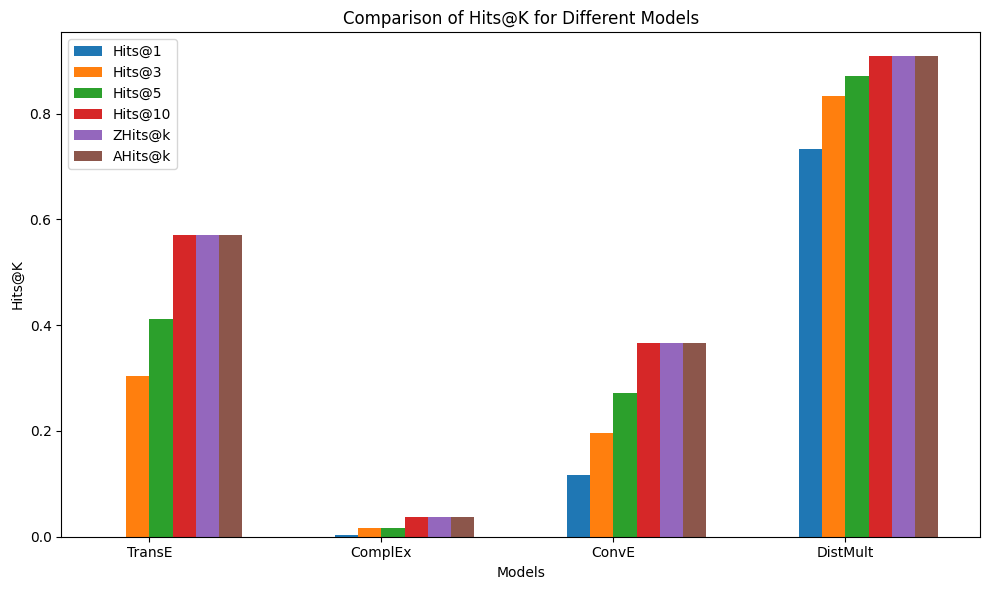

In [123]:
#Plot hits, many = good
models = ['TransE', 'ComplEx', 'ConvE', 'DistMult']
hits_at_1 = [transE_hits['Hits@1'], complEx_hits['Hits@1'], convE_hits['Hits@1'], distMult_hits['Hits@1']]
hits_at_3 = [transE_hits['Hits@3'], complEx_hits['Hits@3'], convE_hits['Hits@3'], distMult_hits['Hits@3']]
hits_at_5 = [transE_hits['Hits@5'], complEx_hits['Hits@5'], convE_hits['Hits@5'], distMult_hits['Hits@5']]
hits_at_10 = [transE_hits['Hits@10'], complEx_hits['Hits@10'], convE_hits['Hits@10'], distMult_hits['Hits@10']]

z_hits_at_k = [transE_hits['ZHits@k'], complEx_hits['ZHits@k'], convE_hits['ZHits@k'], distMult_hits['ZHits@k']]
adjusted_hits_at_k = [transE_hits['AHits@k'], complEx_hits['AHits@k'], convE_hits['AHits@k'], distMult_hits['AHits@k']]

# Plotting
x = range(len(models))
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each Hits@K metric
ax.bar(x, hits_at_1, width, label='Hits@1')
ax.bar([p + width for p in x], hits_at_3, width, label='Hits@3')
ax.bar([p + width*2 for p in x], hits_at_5, width, label='Hits@5')
ax.bar([p + width*3 for p in x], hits_at_10, width, label='Hits@10')
ax.bar([p + width*4 for p in x], hits_at_10, width, label='ZHits@k')
ax.bar([p + width*5 for p in x], hits_at_10, width, label='AHits@k')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Hits@K')
ax.set_title('Comparison of Hits@K for Different Models')
ax.set_xticks([p + 1.5 * width for p in x])
ax.set_xticklabels(models)

plt.legend()
plt.tight_layout()
plt.savefig("output_images/hits_at_k_comparison.png")
plt.show()

In [124]:
def extract_metrics(results):
    # Extract metrics for the 'both' category
    metrics = results.to_dict()
    
    # Retrieve 'both' metrics
    both_metrics = metrics['both']

    # Extract the 'optimistic' estimates for 'both'
    optimistic = both_metrics['optimistic']
    # Get metrics values for the desired metrics
    extracted_metrics = {
        'variance': optimistic.get('variance', 0),
        'count': optimistic.get('count', 0),
        'standard_deviation': optimistic.get('standard_deviation', 0),
        'inverse_median_rank': optimistic.get('inverse_median_rank', 0),
        'adjusted_geometric_mean_rank_index': optimistic.get('adjusted_geometric_mean_rank_index', 0),
        'z_inverse_harmonic_mean_rank': optimistic.get('z_inverse_harmonic_mean_rank', 0),
        'geometric_mean_rank': optimistic.get('geometric_mean_rank', 0),
        'arithmetic_mean_rank': optimistic.get('arithmetic_mean_rank', 0),
        'inverse_geometric_mean_rank': optimistic.get('inverse_geometric_mean_rank', 0),
        'adjusted_inverse_harmonic_mean_rank': optimistic.get('adjusted_inverse_harmonic_mean_rank', 0),
        'inverse_harmonic_mean_rank': optimistic.get('inverse_harmonic_mean_rank', 0),
        'median_absolute_deviation': optimistic.get('median_absolute_deviation', 0),
        'median_rank': optimistic.get('median_rank', 0),
        'z_geometric_mean_rank': optimistic.get('z_geometric_mean_rank', 0),
        'adjusted_arithmetic_mean_rank': optimistic.get('adjusted_arithmetic_mean_rank', 0),
        'harmonic_mean_rank': optimistic.get('harmonic_mean_rank', 0),
        'inverse_arithmetic_mean_rank': optimistic.get('inverse_arithmetic_mean_rank', 0),
        'z_arithmetic_mean_rank': optimistic.get('z_arithmetic_mean_rank', 0),
        'adjusted_arithmetic_mean_rank_index': optimistic.get('adjusted_arithmetic_mean_rank_index', 0)
        
    }
    
    return extracted_metrics



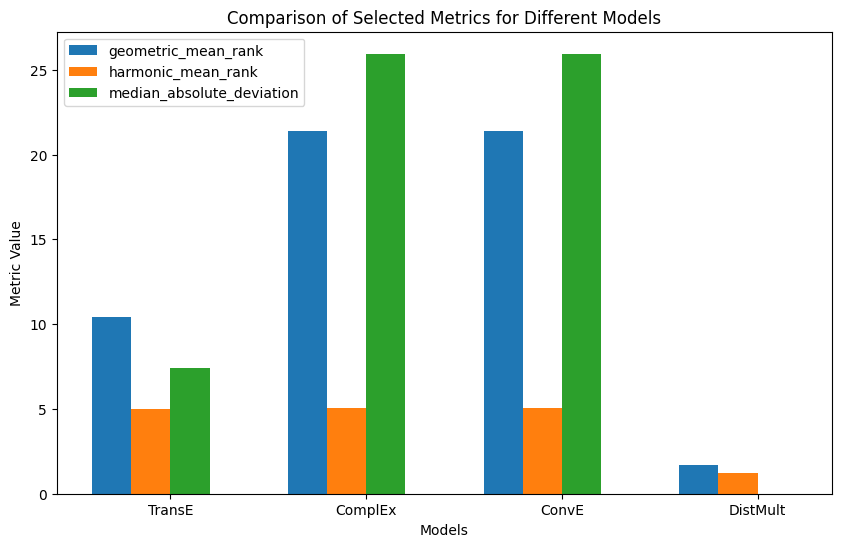

In [125]:
#plot rank low = good
transE_metrics = extract_metrics(transE_results)
convE_metrics = extract_metrics(convE_results)
complEx_metrics = extract_metrics(convE_results)
distMult_metrics = extract_metrics(distMult_results)

# Organize data for plotting
models = ['TransE', 'ComplEx', 'ConvE', 'DistMult']

selected_metrics = ['geometric_mean_rank', 'harmonic_mean_rank','median_absolute_deviation']

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the x locations for the groups
x = range(len(models))
width = 0.2  # the width of the bars

# Iterate through selected metrics and plot them
for i, metric in enumerate(selected_metrics):
    metric_values = [transE_metrics[metric], complEx_metrics[metric], convE_metrics[metric], distMult_metrics[metric]]
    ax.bar([p + width * i for p in x], metric_values, width, label=metric)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Selected Metrics for Different Models')
ax.set_xticks([p + width * len(selected_metrics) / 2 for p in x])
ax.set_xticklabels(models)

plt.legend()
plt.savefig("output_images/selected_metrics_comparison.png")
plt.show()

In [126]:
#UMAP and cosine
# pick the best ranked model
entity_embeddings = distMult_result.model.entity_representations[0](indices=None).cpu().detach().numpy()

# Reduce dimensionality with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(entity_embeddings)

# Create a mapping of entity ID to entity name
entity_id_to_label = {v: k for k, v in triples_factory.entity_to_id.items()}

# Cosine similarity matrix
cosine_sim_matrix = cosine_similarity(entity_embeddings)

# Function to get top N similar entities
def get_top_n_similar_entities(entity, n=5):
    entity_id = triples_factory.entity_to_id[entity]
    sim_scores = cosine_sim_matrix[entity_id]
    top_n_indices = sim_scores.argsort()[-n-1:-1][::-1]
    return [(entity_id_to_label[idx], sim_scores[idx]) for idx in top_n_indices]

# Example: Find entities similar to a given entity
similar_entities = get_top_n_similar_entities('Giacomo Medici', n=5)
print(f"Entities similar to Giacomo Medici: {similar_entities}")

/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entities similar to Giacomo Medici: [('Robert Hecht', np.float32(0.7215416)), ('Gianfranco Becchina', np.float32(0.70506984)), ('Dikran Sarrafian', np.float32(0.6019929)), ('Robin Symes', np.float32(0.60131425)), ('Samuel Schweitzer', np.float32(0.59176755))]


In [127]:
def save_embedding_analysis(model_name, embeddings, reduced_embeddings, sim_results, sim_matrix):
    output_dir = f'results/{model_name}/embedding_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save original high-dimensional embeddings
    np.save(os.path.join(output_dir, 'entity_embeddings.npy'), embeddings)

    # Save 2D UMAP embeddings
    np.save(os.path.join(output_dir, 'umap_embeddings.npy'), reduced_embeddings)

    # Save cosine similarity matrix
    np.save(os.path.join(output_dir, 'cosine_similarity_matrix.npy'), sim_matrix)

    # Convert similarity results to JSON-serializable format
    sim_results_serializable = [(str(entity), float(score)) for entity, score in sim_results]

    # Save sample similarity results
    with open(os.path.join(output_dir, 'similar_entities_Giacomo_Medici.json'), 'w') as f:
        json.dump(sim_results_serializable, f, indent=4)

In [128]:
save_embedding_analysis(
    model_name="DistMult",
    embeddings=entity_embeddings,
    reduced_embeddings=umap_embeddings,
    sim_results=similar_entities,
    sim_matrix=cosine_sim_matrix
)

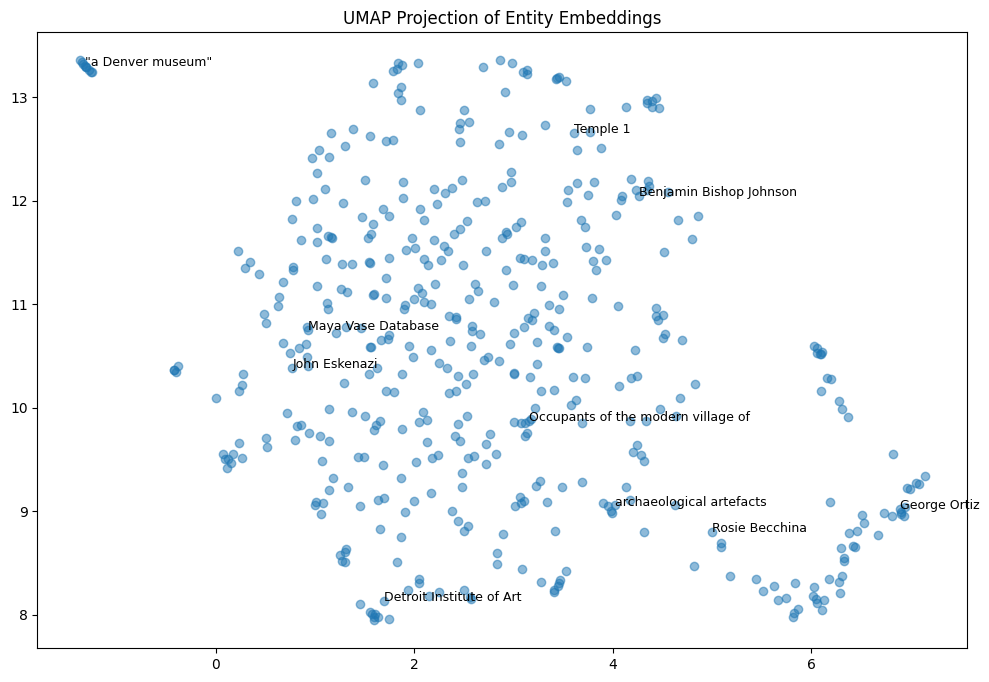

In [129]:
#Plot UMAP projection
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5)

# Annotate some points for clarity
for idx, (x, y) in enumerate(umap_embeddings):
    if idx % 50 == 0:  # Annotate every 50th point to avoid clutter
        plt.text(x, y, entity_id_to_label[idx], fontsize=9)

plt.title('UMAP Projection of Entity Embeddings')
plt.savefig("output_images/umap_similarity_Giacomo_Medici.png")
plt.show()  

## Embedding Models with FAIR


In [12]:
def my_upload(dataframe1):
    dataframe1.to_csv("/home/daria/Uni/InfoSysteme/Data setwardship/trial/full_dataset_with_split.csv", index=True)

In [13]:
# Map triples back to labels
def map_triples(factory, split_name):
    triples = factory.mapped_triples.numpy()
    heads = [entity_id_to_label[int(h)] for h in triples[:, 0]]
    relations = [relation_id_to_label[int(r)] for r in triples[:, 1]]
    tails = [entity_id_to_label[int(t)] for t in triples[:, 2]]
    df = pd.DataFrame({
        'head': heads,
        'relationship': relations,
        'tail': tails,
        'split': split_name
    })
    return df

In [14]:
# 1. Set random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# 2. Split into training, validation, and testing sets
training_factory, testing_factory, validation_factory = triples_factory.split([0.8, 0.1, 0.1])
entity_id_to_label = training_factory.entity_id_to_label
relation_id_to_label = training_factory.relation_id_to_label

# 3. Merge the splits into a single metadata-rich dataset
import pandas as pd

# Assume each factory has .mapped_triples as a numpy array or tensor
train_df = pd.DataFrame(training_factory.mapped_triples.numpy(), columns=["head", "relation", "tail"])
train_df["split"] = "train"

val_df = pd.DataFrame(validation_factory.mapped_triples.numpy(), columns=["head", "relation", "tail"])
val_df["split"] = "validation"

test_df = pd.DataFrame(testing_factory.mapped_triples.numpy(), columns=["head", "relation", "tail"])
test_df["split"] = "test"

# Combine them
train_df = map_triples(training_factory, 'train')
val_df = map_triples(validation_factory, 'validation')
test_df = map_triples(testing_factory, 'test')

# Merge
full_dataset_with_split = pd.concat([train_df, val_df, test_df], ignore_index=True)

# 4. Upload the single dataset

my_upload(full_dataset_with_split)

# 5. Continue training and evaluation
def train_and_evaluate_model(model_cls, training_factory, testing_factory, validation_factory, random_seed):
    pipeline_result = pipeline(
        model=model_cls,
        training=training_factory,
        testing=testing_factory,
        validation=validation_factory,
        training_kwargs=dict(num_epochs=1000),
        random_seed=random_seed,
    )

    evaluator = RankBasedEvaluator()
    results = evaluator.evaluate(
        model=pipeline_result.model,
        mapped_triples=testing_factory.mapped_triples,
        additional_filter_triples=[training_factory.mapped_triples, validation_factory.mapped_triples]
    )

    print(f"{model_cls.__name__} Results:\n")
    print(results.to_dict())

    return pipeline_result, results



using automatically assigned random_state=4289512057


In [16]:
transE_result, transE_results = train_and_evaluate_model(TransE, training_factory, testing_factory, validation_factory, random_seed)
complEx_result, complEx_results = train_and_evaluate_model(ComplEx, training_factory, testing_factory, validation_factory, random_seed)
convE_result, convE_results = train_and_evaluate_model(ConvE, training_factory, testing_factory, validation_factory, random_seed)
distMult_result, distMult_results = train_and_evaluate_model(DistMult, training_factory, testing_factory, validation_factory, random_seed)

No cuda devices were available. The model runs on CPU
/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.28s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds
INFO:pykeen.pipeline.api:Using device: None
/home/daria/Uni/Done/knowledge_graphs/playpen/KG_implementation/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TransE Results:

{'head': {'optimistic': {'standard_deviation': 70.23108236782028, 'median_rank': 6.0, 'adjusted_arithmetic_mean_rank': 0.13395072514415515, 'median_absolute_deviation': 5.930408874022408, 'inverse_arithmetic_mean_rank': 0.031307070180015655, 'z_geometric_mean_rank': 10.717005334648455, 'geometric_mean_rank': 9.225864291212872, 'adjusted_inverse_harmonic_mean_rank': 0.2043147253024838, 'adjusted_geometric_mean_rank_index': 0.9533290865980358, 'variance': 4932.404930555555, 'harmonic_mean_rank': 4.638447272365253, 'inverse_median_rank': 0.16666666666666666, 'inverse_harmonic_mean_rank': 0.2155893861201696, 'inverse_geometric_mean_rank': 0.10839092885340237, 'arithmetic_mean_rank': 31.941666666666666, 'z_arithmetic_mean_rank': 16.46652151692661, 'z_inverse_harmonic_mean_rank': 38.696243860826975, 'adjusted_arithmetic_mean_rank_index': 0.8696964379715739, 'count': 120.0, 'hits_at_1': 0.0, 'hits_at_3': 0.325, 'hits_at_5': 0.45, 'hits_at_10': 0.625, 'z_hits_at_k': 46.1307948

Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.28s seconds
INFO:pykeen.pipeline.api:Using device: None
The ConvE model should be trained with inverse triples.
This can be done by defining the TriplesFactory class with the _create_inverse_triples_ parameter set to true.
INFO:pykeen.nn.modules:Resolving None * None * None = 200.
INFO:pykeen.nn.modules:Resolved to 1 * 20 * 10 = 200.


ComplEx Results:

{'head': {'optimistic': {'standard_deviation': 139.87975391583856, 'median_rank': 219.5, 'adjusted_arithmetic_mean_rank': 0.9333566311375152, 'median_absolute_deviation': 183.10137398544185, 'inverse_arithmetic_mean_rank': 0.004493035794518496, 'z_geometric_mean_rank': 1.6467799401932925, 'geometric_mean_rank': 151.4334344907398, 'adjusted_inverse_harmonic_mean_rank': 0.011916202508973624, 'adjusted_geometric_mean_rank_index': 0.14648898336709992, 'variance': 19566.345555555552, 'harmonic_mean_rank': 38.584560659877724, 'inverse_median_rank': 0.004555808656036446, 'inverse_harmonic_mean_rank': 0.025917102149094914, 'inverse_geometric_mean_rank': 0.006603561514423357, 'arithmetic_mean_rank': 222.56666666666666, 'z_arithmetic_mean_rank': 1.2671155085456824, 'z_inverse_harmonic_mean_rank': 2.2568724672173004, 'adjusted_arithmetic_mean_rank_index': 0.06692402175820333, 'count': 120.0, 'hits_at_1': 0.008333333333333333, 'hits_at_3': 0.025, 'hits_at_5': 0.025, 'hits_at_10':

Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3 (33.33%) batches).


Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/3 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.70s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.77s seconds
INFO:pykeen.pipeline.api:Using device: None


ConvE Results:

{'head': {'optimistic': {'standard_deviation': 109.56395392646252, 'median_rank': 14.5, 'adjusted_arithmetic_mean_rank': 0.30487506552507426, 'median_absolute_deviation': 20.015129949825628, 'inverse_arithmetic_mean_rank': 0.013755158184319119, 'z_geometric_mean_rank': 10.252761561422952, 'geometric_mean_rank': 16.504512406288143, 'adjusted_inverse_harmonic_mean_rank': 0.23177413510363173, 'adjusted_geometric_mean_rank_index': 0.912032373713418, 'variance': 12004.260000000002, 'harmonic_mean_rank': 4.120997379293598, 'inverse_median_rank': 0.06896551724137931, 'inverse_harmonic_mean_rank': 0.24265970297011333, 'inverse_geometric_mean_rank': 0.060589490642510874, 'arithmetic_mean_rank': 72.7, 'z_arithmetic_mean_rank': 13.216672564489837, 'z_inverse_harmonic_mean_rank': 43.89692636849489, 'adjusted_arithmetic_mean_rank_index': 0.6980522898754168, 'count': 120.0, 'hits_at_1': 0.14166666666666666, 'hits_at_3': 0.25, 'hits_at_5': 0.35833333333333334, 'hits_at_10': 0.43333333

Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/120 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds


DistMult Results:

{'head': {'optimistic': {'standard_deviation': 39.91093469631264, 'median_rank': 1.0, 'adjusted_arithmetic_mean_rank': 0.035540800279573646, 'median_absolute_deviation': 0.0, 'inverse_arithmetic_mean_rank': 0.11799410029498525, 'z_geometric_mean_rank': 11.196859823870966, 'geometric_mean_rank': 1.702463494206823, 'adjusted_inverse_harmonic_mean_rank': 0.8022614131086427, 'adjusted_geometric_mean_rank_index': 0.9960144476318203, 'variance': 1592.882708333332, 'harmonic_mean_rank': 1.2421383213299926, 'inverse_median_rank': 1.0, 'inverse_harmonic_mean_rank': 0.8050633193002787, 'inverse_geometric_mean_rank': 0.5873841074436075, 'arithmetic_mean_rank': 8.475, 'z_arithmetic_mean_rank': 18.337626536362702, 'z_inverse_harmonic_mean_rank': 151.9445220398233, 'adjusted_arithmetic_mean_rank_index': 0.9685207931216003, 'count': 120.0, 'hits_at_1': 0.75, 'hits_at_3': 0.825, 'hits_at_5': 0.8666666666666667, 'hits_at_10': 0.9083333333333333, 'z_hits_at_k': 67.77096537158087, 'adj

## Labels

In [130]:
import pandas as pd
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os

# Connect to Neo4j
uri = "bolt://localhost:7687"  # Default
load_dotenv()
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(uri, auth=(username, password))



In [131]:
# Function to create nodes and relationships
def create_graph(tx, head, relationship, tail):
    query = (
        "MERGE (a:Node {name: $head}) "
        "MERGE (b:Node {name: $tail}) "
        "MERGE (a)-[r:" + relationship + "]->(b)"
    )
    tx.run(query, head=head, tail=tail)

In [132]:
def clear_neo4j_database(driver):
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    print("✅ All nodes and relationships have been deleted.")

In [109]:
clear_neo4j_database(driver)

✅ All nodes and relationships have been deleted.


In [133]:
# Upload data to Neo4j
#Run just once!
with driver.session() as session:
    for index, row in dataset.iterrows():
        session.execute_write(create_graph, row['head'], row['relationship'], row['tail'])

In [134]:
def count_entities_and_relationships(session):
    # Count nodes
    node_count = session.run("MATCH (n) RETURN count(n) AS node_count").single()["node_count"]
    # Count relationships
    relationship_count = session.run("MATCH ()-[r]->() RETURN count(r) AS relationship_count").single()["relationship_count"]
    return node_count, relationship_count

# Query the Graph Database
with driver.session() as session:
    nodes, relationships = count_entities_and_relationships(session)
    print(f"Number of nodes: {nodes}")
    print(f"Number of relationships: {relationships}")

#Number of nodes: 477
#Number of relationships: 1204

Number of nodes: 477
Number of relationships: 1204


In [136]:
#check existing labels
def list_labels(session):
    query = "CALL db.labels()"
    result = session.run(query)
    labels = [record["label"] for record in result]
    return labels
with driver.session() as session:
    labels = list_labels(session)
    print("Available labels in the database:")
    for label in labels:
        print(label)

Available labels in the database:
Node


In [137]:
def fetch_nodes(tx):
    query = "MATCH (n) RETURN n"
    result = tx.run(query)
    return [record["n"] for record in result]

with driver.session() as session:
    nodes = session.execute_read(fetch_nodes)

def remove_special_characters(s):
    # Define the characters to remove
    chars_to_remove = ["‘", "&", "||", "'"]
    for char in chars_to_remove:
        s = s.replace(char, " ")
    return s

def preprocess_node(node):
    # Example: extracting labels and properties
    labels = node.labels   
    properties = dict(node)  # Convert properties to a dictionary
    return labels, properties

node_data = [preprocess_node(node) for node in nodes]
texts_raw = [properties['name'] for labels, properties in node_data if 'name' in properties]

texts = [remove_special_characters(t) for t in texts_raw]
print(texts)

['Abraham Trust', 'Geoffrey Jenkinson', 'Benjamin Bishop Johnson', 'David Swetnam', 'Donald Hales', 'Leonardo Patterson', 'Giacomo Medici', 'Nikolas Koutoulakis', 'Jack Ogden', 'Michael Ward Gallery', 'Joel Malter', 'Robert Olson', 'John Betts', 'Paul Clifford', 'Roxanna Brown', 'Jonathan and Cari Markell', 'Edward Johnson', 'Immigration and Customs Enforcement', 'Carabinieri', 'Dikran Sarrafian', 'Euphronios ( Sarpedon ) krater', 'Precolumbian art', 'Barry MacLean', 'Ban Chiang pottery', 'Berry   Stark Associates', 'El Zotz Wooden Lintel', 'Art Gallery of New South Wales', 'dragon ewers', 'British Museum', 'Nelson Rockefeller', 'Loma Negra', 'Peter G Wray', 'mask made of fuschite depicting the sun god', 'Michigan-based Orpheus Art', 'Predynastic opium poppy vase', 'Robin Symes', 'Morgantina Venus', 'sealstones', 'Leon Levy', 'second Euphronios krater', 'Shelby White', 'J Paul Getty Museum', 'Fifth-century BC Attic red-figured kylix, signed by Euphronios as potter and painted by Onesim

In [138]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def has_two_words(s):
    words = s.split()
    return len(words) == 2 or len(words) == 3

def categorize_text(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc]

    if any(word in tokens for word in ["museum", "gallery", "collection", "border", "customs", "security", "inland", "national", "force", "and", "&"]):
        return "institution"
    elif any(word in tokens for word in ["country", "nation", "state", "europe", "location", "geographic", "region"]):
        return "country"
    elif any(word in tokens for word in ["sculpture", "figurine", "painting", "mosaic", "artefact", "jewelry", "coin", "art", "mask", "depiction", "representation", "figure", "antiquity", "piece", "fragment", "pottery", "shard", "amphora", "cloth", "textile", "vessle"]):
        return "artefact"
    elif has_two_words(text):
        return "person"
    else:
        return "unclassified_entity"

# Run categorization
label_results = [(text, categorize_text(text)) for text in texts]

# Save results to CSV
df_lab = pd.DataFrame(label_results, columns=["text", "label"])
df_lab.to_csv("results/generated_labels.csv", index=False)

# Print results
for text, label in label_results:
    print(f"'{text}' is classified as: {label}")


'Abraham Trust' is classified as: person
'Geoffrey Jenkinson' is classified as: person
'Benjamin Bishop Johnson' is classified as: person
'David Swetnam' is classified as: person
'Donald Hales' is classified as: person
'Leonardo Patterson' is classified as: person
'Giacomo Medici' is classified as: person
'Nikolas Koutoulakis' is classified as: person
'Jack Ogden' is classified as: person
'Michael Ward Gallery' is classified as: institution
'Joel Malter' is classified as: person
'Robert Olson' is classified as: person
'John Betts' is classified as: person
'Paul Clifford' is classified as: person
'Roxanna Brown' is classified as: person
'Jonathan and Cari Markell' is classified as: institution
'Edward Johnson' is classified as: person
'Immigration and Customs Enforcement' is classified as: institution
'Carabinieri' is classified as: unclassified_entity
'Dikran Sarrafian' is classified as: person
'Euphronios ( Sarpedon ) krater' is classified as: unclassified_entity
'Precolumbian art' is

In [139]:
#upload labels
queries = []
for text, label in label_results:
    query = f"""
    MATCH (n {{name: '{text}'}})
    SET n:{label}
    """
    queries.append(query)

def execute_queries(queries):
    with driver.session() as session:
        for query in queries:
            session.run(query)

# Execute the queries to update the node labels
execute_queries(queries)

In [140]:
#check existing labels
def list_labels(session):
    query = "CALL db.labels()"
    result = session.run(query)
    labels = [record["label"] for record in result]
    return labels
with driver.session() as session:
    labels = list_labels(session)
    print("Available labels in the database:")
    for label in labels:
        print(label)

Available labels in the database:
Node
person
institution
artefact
unclassified_entity
